# Dask Tutorial Notebook
<hr>

# Notebook Description

This notebook serves as an introduction to [Dask](https://dask.org/), which is a software library that allows us to scale analyses to large datasets. This notebook covers both what it is and how to use it, particularly in the context of the Open Data Cube. This notebook is strongly inspired by [the Digital Earth Africa Dask tutorial notebook](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Beginners_guide/08_Parallel_processing_with_dask.ipynb).

<hr>

# <a id="Dask_Tutorial_Notebook_index"></a>Index

* [What is Dask?](#Dask_Tutorial_Notebook_what_is_dask)
* [Import Dependencies and Connect to the Data Cube](#Dask_Tutorial_Notebook_import)
* [Define the Extents of the Analysis](#Dask_Tutorial_Notebook_define_extents)
* [Standard Load](#Dask_Tutorial_Notebook_standard_load)
* [Creating a Dask Client and Cluster](#Dask_Tutorial_Notebook_create_client_cluster)
* [View the Dask Dashboard](#Dask_Tutorial_Notebook_view_dashboard)
* [Lazy Load with Dask](#Dask_Tutorial_Notebook_lazy_load)
* [Viewing Dask Chunks](#Dask_Tutorial_Notebook_view_chunks)
* [Viewing Task Graphs](#Dask_Tutorial_Notebook_view_task_graph)
* [Running a Task Graph (Loading)](#Dask_Tutorial_Notebook_run_task_graph)
* [Adding More Tasks](#Dask_Tutorial_Notebook_add_tasks)
* [Persisting Data](#Dask_Tutorial_Notebook_persist)
* [Dask Resilience and Recovery](#Dask_Tutorial_Notebook_resilience_recovery)
* [Chunking Strategies](#Dask_Tutorial_Notebook_chunking_strategies)
* [Machine Learning with Dask](#Dask_Tutorial_Notebook_machine_learning)

## <span id="Dask_Tutorial_Notebook_what_is_dask">What is Dask? [&#9652;](#Dask_Tutorial_Notebook_index)</span>

Dask is a useful tool when working with large analyses - whether in space, time, or data density (amount of data per pixel) - as it breaks data into manageable chunks that can be easily stored in memory.
It can also use multiple computing cores to speed up computations.

It does all of this by creating a [task graph](https://docs.dask.org/en/latest/graphs.html). When applying operations to data loaded from the Data Cube normally, operations occur immediately. However, when using Dask, operations instead become plans to perform them based on how the data is chunked. How the data is chunked is specified in the arguments to `datacube.Datacube.load()` calls.

You can read the Dask documentation [here](https://docs.dask.org/en/latest/).

You can read more about how xarray integrates with Dask [here](http://xarray.pydata.org/en/stable/dask.html).

## <span id="Dask_Tutorial_Notebook_import">Import Dependencies and Connect to the Data Cube [&#9652;](#Dask_Tutorial_Notebook_index)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dask import create_local_dask_cluster

import datacube

dc = datacube.Datacube(app="Dask_Tutorial_Notebook")

## <span id="Dask_Tutorial_Notebook_define_extents">Define the Extents of the Analysis [&#9652;](#Dask_Tutorial_Notebook_index)</span>

Here we define an area of interest and examine it on a map.

In [2]:
# Freetown, Sierra Leone (small)
x=(-13.3422, -13.1396)
y=(8.2968, 8.5076)

display_map(y,x)

## <span id="Dask_Tutorial_Notebook_standard_load">Standard Load [&#9652;](#Dask_Tutorial_Notebook_index)</span>

By default, the `datacube` library will **not** use Dask when loading data.
This means that when `dc.load()` is used, all data relating to the load query will be requested and loaded into memory.

For very large areas or long time spans, this can cause the Jupyter notebook to crash.

Below, we show a standard load example.

In [3]:
common_load_params = dict(product='ls8_usgs_sr_scene',
                          measurements=['red', 'green', 'blue'],
                          x=x, y=y, time=("2017-01-01", "2017-12-31"),
                          output_crs='EPSG:4326', resolution=(-0.00027, 0.00027))

In [4]:
%%time
data = dc.load(**common_load_params)
data

CPU times: user 1.94 s, sys: 1.39 s, total: 3.33 s
Wall time: 6.04 s


<xarray.Dataset>
Dimensions:      (latitude: 782, longitude: 751, time: 5)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-03T11:10:18.493759 ... 2017-09...
  * latitude     (latitude) float64 8.508 8.507 8.507 ... 8.297 8.297 8.297
  * longitude    (longitude) float64 -13.34 -13.34 -13.34 ... -13.14 -13.14
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 7280 7297 7307 ... 233 233
    green        (time, latitude, longitude) int16 7218 7233 7245 ... 424 423
    blue         (time, latitude, longitude) int16 7158 7182 7192 ... 290 291
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Take note of how long the load took ("**Wall time**" in the output of the cell above).

## <span id="Dask_Tutorial_Notebook_create_client_cluster">Creating a Dask Client and Cluster [&#9652;](#Dask_Tutorial_Notebook_index)</span>

To use Dask, you need to first set up a Dask client and cluster. The client allows access to the cluster. There are 2 main methods for doing this: the preferred method and an advanced method that should be used in a JupyterLabs environment when either the preferred method does not work or both the JupyterLabs Dask menu allows creation of a distributed cluster (not a local cluster, which is created by default unless the JupyterLabs environment is configured otherwise) AND scalability is desired.

>### Enabling Dask - Preferred, Convenient Method

The preferred way to create a Dask cluster which works in and outside Jupyter environments is by using the `create_local_dask_cluster()` function (see imports above for utils path), as used in the cell below. This function creates a Dask cluster on your Jupyter server, so it will share compute resources like CPU, memory, and storage with your Jupyter server. **This cluster cannot scale up in resources beyond your Jupyter server's resources.**

This is preferred for these reasons:

1. It works anywhere Dask is available - not just in Jupyter environments.
2. It allows notebooks that use Dask to be easily run by tools that run notebooks automatically (good for testing).

In [5]:
client = create_local_dask_cluster()
client

Client Scheduler: tcp://127.0.0.1:38947 Dashboard: /user/jcrattz/proxy/8787/status,Cluster Workers: 7 Cores: 14 Memory: 14.18 GB


A printout should appear, displaying information about the `Client` and the `Cluster`.

>### Enabling Dask - Advanced Method (JupyterLabs)

On the left-hand menu bar, click the Dask icon, as shown below:

![Image](images/dask.png)

Click the "+ New" button to create a new Dask cluster.

![Image](images/JupyterLabs_new_dask_cluster_button.png)

You should now see a new Dask Dashboard URL.

![Image](images/JupyterLabs_dask_daskboard_url.png)

Clicking on a cluster in the clusters list sets the dashboard URL to the one for that cluster. This changes what cluster is being monitored by the JupyterLabs Dask plugin, but note that the cluster used by code depends on what cluster the Dask `client` is connected to in that code's context (e.g. a Jupyter notebook).

To create a client for this cluster, click and drag the cluster into a notebook. This will create a cell that creates a Dask client called `client`.

Here is what dragging the cluster entry into a notebook looks like:

![Image](images/JupyterLabs_drag_and_drop_dask_client_code.png)

This is the resulting cell that creates the Dask client for the selected cluster:

![Image](images/JupyterLabs_dask_client_code_cell.png)

Note that in this example, the cluster is local. On JupyterLabs servers that only create local Dask clusters like this, this method is only to be used if the `create_local_dask_cluster()` function is not available.

>### Enabling Dask - Final Fallback

If none of the above methods of creating a Dask client and cluster work, then continue without them. The code should still work, but you will not be able to view the Dask dashboard (to monitor the Dask cluster) or perform actions that require a Dask client object.

## <span id="Dask_Tutorial_Notebook_view_dashboard">View the Dask Dashboard [&#9652;](#Dask_Tutorial_Notebook_index)</span>

For now, we're mostly interested in the hyperlink after the **Dashboard** heading, which should look something like **/user/\<username\>/proxy/\<port\>/status**, where **\<username\>** is your username on the Jupyter server. The full URL to the dashboard is that URL prefixed with the domain. For example, if your JupyterLabs server URL is **odc.sandbox/user/me/lab**, and your dashboard URL is **/user/me/proxy/8787/status** or something like **http:\/\/127.0.0.1:8787/status**, then your full dashboard URL is **odc.sandbox/user/me/proxy/8787/status**.

The **Dashboard** link for the client creation cell in a notebook will open a new tab in your browser to the Dask dashboard for that cluster, which allows you to monitor that Dask cluster - including real-time task progress.

There are 2 ways to view the dashboard:
1. Navigate to the dashboard in your browser, such as by clicking the dashboard URL in the printout for the `client` in the notebook.
2. Set up the dashboard inside the JupyterLabs Environment. This does not require a different browser tab for the dashboard.

We'll now cover how to do the second option.

>### Dask dashboard inside JupyterLabs (no extra browser tabs)

On the left-hand menu bar, click the Dask icon, as shown below:

![Image](images/dask.png)

Copy and paste the **Dashboard** link from the Client print out into the DASK DASHBOARD URL text box (may need to account for a format like 127.0.0.1, as mentioned previously):

![Image](images/dask_url_filled.png)

If the URL is valid, the buttons should change color from grey to orange.
Click the orange **PROGRESS** button on the Dask panel, which will open a new tab inside the JupyterLabs environment.

To view the Dask window and your active notebook at the same time, drag the new Dask Progress tab to the bottom of the screen.

![Image](images/JupyterLabs_dask_progress_pane.png)

Now, when you do computations with Dask, you'll see the progress of the computations in this new Dask window.

## <span id="Dask_Tutorial_Notebook_lazy_load">Lazy Load with Dask [&#9652;](#Dask_Tutorial_Notebook_index)</span>

To use Dask with ODC data, specify a `dask_chunks` argument to `datacube.Datacube.load()` calls. This argument is a dictionary specifying what chunk size to use for each dimension (x, y, time). If no chunk size is specified for a dimension, or if it is set to `-1`, or if the specified chunk size exceeds the length of that dimension of the data, then the chunk size is the length of that dimension of the data.

Here, we load data with Dask - specifically with a chunk size of `{'time': 20, 'x': 3000, 'y': 3000}`.

When using Dask, the `datacube.Datacube.load()` function will switch from immediately loading the data to "lazy-loading" the data. This means the data is only loaded when the task graph is run (when the data is needed). 

Using Dask changes the data structure returned from `datacube.Datacube.load()`: the returned `xarray.Dataset` will be comprised of `dask.array` objects instead of `numpy.ndarray` objects.

The following is an example of lazy loading data with Dask:

In [6]:
%%time
lazy_data = dc.load(**common_load_params, 
                    dask_chunks={'time': 1, 'longitude': 3000, 'latitude': 3000})

lazy_data

CPU times: user 26.4 ms, sys: 5.55 ms, total: 32 ms
Wall time: 35 ms


<xarray.Dataset>
Dimensions:      (latitude: 782, longitude: 751, time: 5)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-03T11:10:18.493759 ... 2017-09...
  * latitude     (latitude) float64 8.508 8.507 8.507 ... 8.297 8.297 8.297
  * longitude    (longitude) float64 -13.34 -13.34 -13.34 ... -13.14 -13.14
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 dask.array<chunksize=(1, 782, 751), meta=np.ndarray>
    green        (time, latitude, longitude) int16 dask.array<chunksize=(1, 782, 751), meta=np.ndarray>
    blue         (time, latitude, longitude) int16 dask.array<chunksize=(1, 782, 751), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

The function should return much faster than the standard load because it is not loading any data.

## <span id="Dask_Tutorial_Notebook_view_chunks">Viewing Dask Chunks [&#9652;](#Dask_Tutorial_Notebook_index)</span>

To get a visual intuition for how the data has been broken into chunks, we can use the `.data` attribute provided by the `xarray.Dataset` from `datacube.Datacube.load()`. 
This attribute can be used on individual measurements from the lazy-loaded data.
When used in a Jupyter Notebook, it provides a table summarising the size of individual chunks and the number of chunks needed.

An example is shown below, using the `red` measurement from the lazy-loaded data:

In [7]:
lazy_data.red.data

dask.array<dc_load_red, shape=(5, 782, 751), dtype=int16, chunksize=(1, 782, 751), chunktype=numpy.ndarray>

From the **Chunk** column of the table, we can see that the data has been broken into 4 chunks, with each chunk having a shape of `(1 time, 782 pixels, 782 pixels)` and taking up 1.17 MB of memory. 
Comparing this with the **Array** column, using Dask means that we can load 5 chunks of 1.17 MB rather than one chunk of 5.87 MB.

Breaking large datasets into chunks and loading chunks one at a time means that you can do computations over large areas and time spans without crashing the Python kernel by running out of memory.

## <span id="Dask_Tutorial_Notebook_view_task_graph">Viewing Task Graphs [&#9652;](#Dask_Tutorial_Notebook_index)</span>

When using lazy-loading, Dask breaks up the loading operation into a series of steps.
A useful way to visualise the steps is the task graph, which can be accessed by adding the `.visualize()` method to a `.data` call:

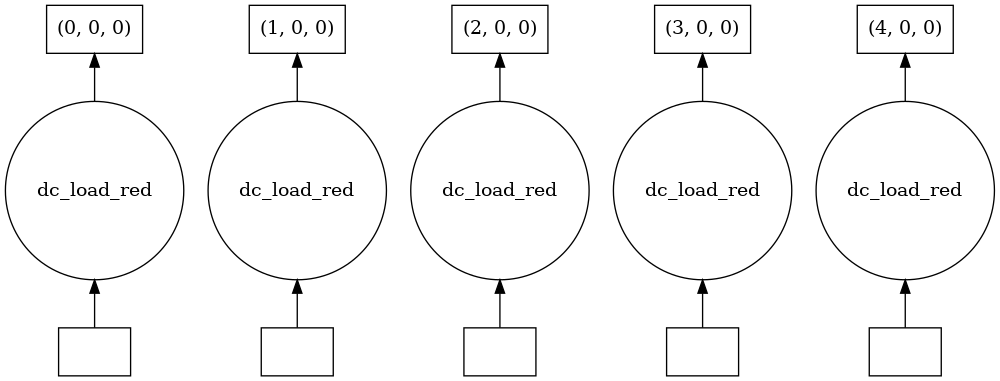

In [8]:
lazy_data.red.data.visualize()

**The task graph is read from bottom to top.**

1. The 5 rectangles at the bottom of the graph are the database entries describing the files that need to be read to load the data.

2. Above the rectangles are individual load commands that will do the reading.
There is one for each chunk.
The arrows describe which files need to be read for each operation.

3. At the very top are the indexes of the chunks that will make up the final array.

## <span id="Dask_Tutorial_Notebook_run_task_graph">Running a Task Graph (Loading) [&#9652;](#Dask_Tutorial_Notebook_index)</span>

When working with lazy-loaded data, you have to specifically ask Dask to run a task graph to obtain the results. 
Until you do this, the task graph only knows what to do, not the results.

To obtain a task graph result and return it as an `xarray.Dataset` with real values (data being held in `numpy.ndarray` objects, not `dask.array` objects), call `.compute()` on the `DataArray` or `Dataset`.
If you opened the Dask progress or graph window, you should see the computation proceed there.

In [9]:
loaded_data = lazy_data.compute()

In [10]:
loaded_data

<xarray.Dataset>
Dimensions:      (latitude: 782, longitude: 751, time: 5)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-03T11:10:18.493759 ... 2017-09...
  * latitude     (latitude) float64 8.508 8.507 8.507 ... 8.297 8.297 8.297
  * longitude    (longitude) float64 -13.34 -13.34 -13.34 ... -13.14 -13.14
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 7280 7297 7307 ... 233 233
    green        (time, latitude, longitude) int16 7218 7233 7245 ... 424 423
    blue         (time, latitude, longitude) int16 7158 7182 7192 ... 290 291
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

The Dask arrays constructed by the lazy load looked like this:
```
red      (time, latitude, longitude) int16 dask.array<chunksize=(1, 782, 751), meta=np.ndarray>
```

But the result of calling `compute()` on the `lazy_data` xarray object is:
```
red      (time, latitude, longitude) int16 7280 7297 7307 ... 233 233
```

So the result is the same as the data loaded from the first query (`data`).

## <span id="Dask_Tutorial_Notebook_add_tasks">Adding More Tasks [&#9652;](#Dask_Tutorial_Notebook_index)</span>

Now lets add more tasks to the task graph than just loading the data.

We will calculate the mean of the red band across time and then view the new task graph:

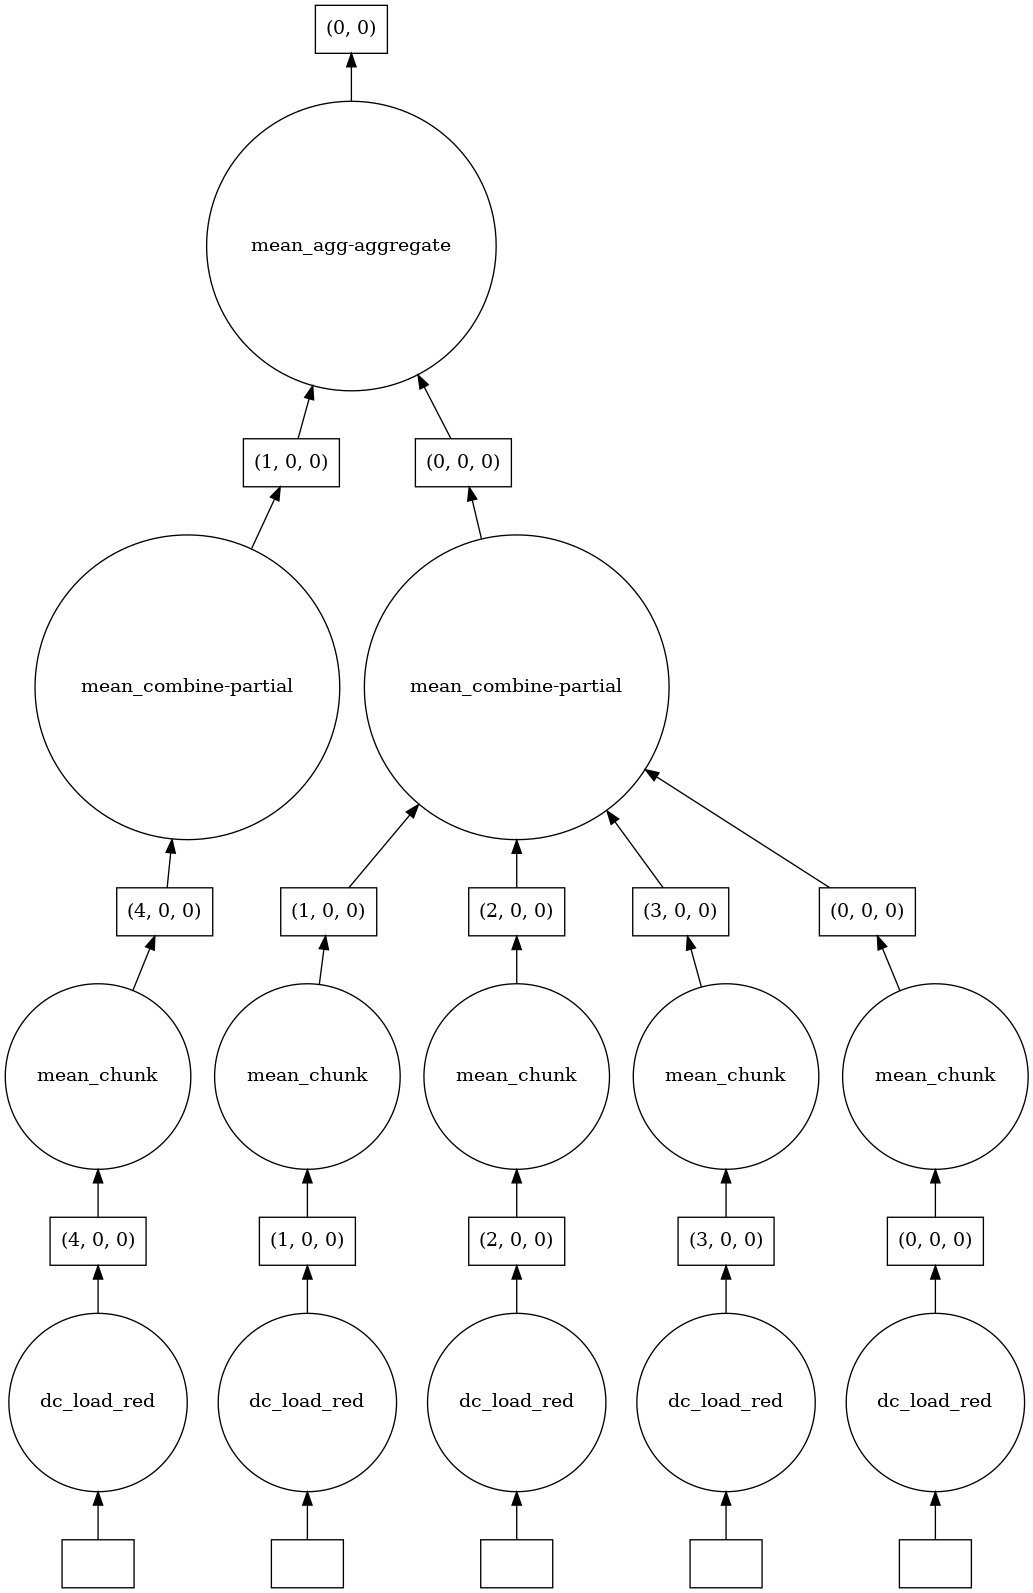

In [11]:
lazy_data.red.mean('time').data.visualize()

## <span id="Dask_Tutorial_Notebook_persist">Persisting Data [&#9652;](#Dask_Tutorial_Notebook_index)</span>

As discussed previously, calling `compute()` on Dask data will cause the task graph to be processed and the result to be brought into memory.

However, there are times that temporary, intermediate results need to be kept in memory to be reused in a task graph rather than recomputed.

First, we need to load more data with larger chunks to see a significant performance difference.

In [34]:
# Freetown, Sierra Leone (large)
x=(-13.3422, -12.8890)
y=(8.0670, 8.5076)

In [38]:
%%time
lazy_data_large = dc.load(product='ls8_usgs_sr_scene',
                          measurements=['red', 'blue'],
                          x=x, y=y, time=("2015-01-01", "2017-12-31"),
                          output_crs='EPSG:4326', resolution=(-0.00027, 0.00027),
                          dask_chunks={'time': 20, 'longitude': 3000, 'latitude': 3000})
lazy_data_large

CPU times: user 126 ms, sys: 1.44 ms, total: 128 ms
Wall time: 136 ms


<xarray.Dataset>
Dimensions:      (latitude: 1633, longitude: 1679, time: 87)
Coordinates:
  * time         (time) datetime64[ns] 2015-04-18T11:04:07.257893 ... 2017-12...
  * latitude     (latitude) float64 8.508 8.507 8.507 ... 8.067 8.067 8.067
  * longitude    (longitude) float64 -13.34 -13.34 -13.34 ... -12.89 -12.89
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) int16 dask.array<chunksize=(20, 1633, 1679), meta=np.ndarray>
    blue         (time, latitude, longitude) int16 dask.array<chunksize=(20, 1633, 1679), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

Consider the following 2 task graphs: 1 computes the difference of the `red` and `blue` bands and the other computes the difference of the `blue` and `red` bands.

In [39]:
lazy_red_minus_blue = lazy_data_large.red - lazy_data_large.blue
lazy_blue_minus_red = lazy_data_large.blue - lazy_data_large.red

See how long these 2 graphs take to run.

In [40]:
%%time
lazy_red_minus_blue.compute()
lazy_blue_minus_red.compute()
print()


CPU times: user 2.02 s, sys: 2.07 s, total: 4.09 s
Wall time: 36 s


In contrast to `compute()` which stores results in the calling context, `persist()` stores results in Dask to be reused.

Note that `persist()` is "non-blocking", or "asynchronous", so although it does process the task graph up to the temporary result referenced by the object `persist()` is called on, it does so in the background, so the `persist()` call terminates very quickly even for large task graphs.

Calling `persist()` on `lazy_data_large` will load the data into Dask's memory.

In [41]:
%%time
lazy_data_large = lazy_data_large.persist()
print()


CPU times: user 165 ms, sys: 0 ns, total: 165 ms
Wall time: 160 ms


Wait a few seconds after the above cell has finished, and then run the following cell to see how long it takes to compute the 2 task graphs we did previously. You can track the progress in the Dask dashboard.

In [42]:
lazy_red_minus_blue = lazy_data_large.red - lazy_data_large.blue
lazy_blue_minus_red = lazy_data_large.blue - lazy_data_large.red

In [43]:
%%time
lazy_red_minus_blue.compute()
lazy_blue_minus_red.compute()
print()


CPU times: user 718 ms, sys: 1.75 s, total: 2.47 s
Wall time: 3.74 s


In this case, these 2 task graphs `compute()` is several times faster if the data is already loaded by calling `persist()` on it instead of loading it for each task graph. Most of the time taken in the first example (without `persist()`) was in loading the data 2 times.

**WARNING:** Generally, `persist()` should not be run on a task graph that will only load data, because there may not be enough memory to hold all of this data. Either scale up the resources of your Dask cluster temporarily, or if that is not possible, examine your full notebook algorithm (how the data is processed) to see if there is a temporary result that is smaller than the full loaded dataset (e.g. composites).

You can read more about managing memory with Dask [here](https://distributed.dask.org/en/latest/memory.html).

## <span id="Dask_Tutorial_Notebook_resilience_recovery">Dask Resilience and Recovery [&#9652;](#Dask_Tutorial_Notebook_index)</span>

Dask is very fault-tolerant. If a worker becomes unresponsive, it will be replaced by another worker. When this happens, the original worker's data is lost and must be reobtained by another worker.

**WARNING:** If the total amount of data required for a `persist()` or `compute()` surpasses the amount of free data across the cluster, then the cluster can get stuck in an infinite loop of trying to obtain the results and having all workers fail due to memory exhaustion. This will continue to waste resources until the task is cancelled or the workers are stopped.

Dask tasks can be stopped by the client. For a client object called `client` and a cancellable object `obj`, `client.cancel(obj)` terminates processing of the task graph associated with `obj`. So **this requires a Dask client object**. **If you do not have a Dask client object, then be very careful what you tell Dask to do because it cannot be cancelled**.

The following example attempts to load a lot of data and persist it. 

In [19]:
x=(-13.4699, -11.9100)
y=(7.3398, 8.5804)

In [20]:
%%time
lazy_data_large = dc.load(product='ls8_usgs_sr_scene',
                          measurements=['red', 'blue'],
                          x=x, y=y, time=("2015-01-01", "2017-12-31"),
                          output_crs='EPSG:4326', resolution=(-0.00027, 0.00027),
                          dask_chunks={'time': 40, 'longitude': 3000, 'latitude': 3000})

CPU times: user 342 ms, sys: 3.16 ms, total: 345 ms
Wall time: 358 ms


In [ ]:
if client is not None:
    lazy_data_large.persist()

Xarray objects containing Dask arrays constitute cancellable objects for a Dask client. So we can simply do the following to terminate the processing for this load:

In [21]:
if client is not None:
    client.cancel(lazy_data_large)

## <span id="Dask_Tutorial_Notebook_chunking_strategies">Chunking Strategies [&#9652;](#Dask_Tutorial_Notebook_index)</span>

Determining chunk sizes is not always easy, but there are several guidelines to remember. When loading data from remote data sources, such as S3, using `'time': 1` in `dask_chunks` can often result in faster loads by loading from multiple files/objects (e.g. Cloud Optimized GeoTIFFs, 1 per acquisition) simultaneously. The spatial dimensions (`x`/`longitude`, `y`/`latitude`) can then be set to any values, but they are usually set to the same value. This value needs to be low enough that the Dask workers do not infinitely crash and restart due to insufficient memory, but otherwise as high as possible to reduce runtime (task graph processing overhead - management). A good default setting for `dask_chunks` for data on remote data sources is `{'time': 1, 'longitude': 3000, 'latitude': 3000}`.

If you are going to immediately create a composite with the loaded data, then using a larger chunk size for the `time` dimension than `1` is advised, such as `10`, since this will reduce communication between Dask workers.

Some operations will require a lot of memory. When using such operations, reduce whatever chunk sizes you can to avoid exhausting the free memory of the Dask workers.

You can use the [`rechunk()`](https://docs.dask.org/en/latest/array-chunks.html#rechunking) method to change the chunk size. Sometimes this is required. For example, in some older versions of Dask, (using Dask 2.19, xarray 0.16.0, and NumPy 1.19.0), the `median()` method of Dask arrays did not work along a dimension unless the chunk size for that dimension is the dimension's length. In this scenario, one must `rechunk()`, then run `median()`, then `rechunk()` to the original chunk size, if desired. This specific issue was fixed some time before Dask 2.19, but this occasional chunking constraint still occurs.

You can read more about Dask chunks [here](https://docs.dask.org/en/latest/array-chunks.html).

## <span id="Dask_Tutorial_Notebook_machine_learning">Machine Learning with Dask [&#9652;](#Dask_Tutorial_Notebook_index)</span>

To do distributed machine learning with Dask, you can use [Dask-ML](https://ml.dask.org/).

You can read [the documentation](https://examples.dask.org/machine-learning.html) for examples of how to use Dask-ML.

As of the time of drafing this document, you can fit a scikit-learn classifier (`clf`) to features (`X`) and labels (`y`) - which are `dask.array` objects or `xarray.DataArray` objects containing `dask.array` objects - in parallel on a Dask cluster with code like this:

```
import joblib

with joblib.parallel_backend('dask'):
    clf.fit(X, y)
```

You can predict with a trained scikit-learn classifier in parallel on a Dask cluster by using [`ParallelPostFit`](https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html) with code like this:

```
clf = ParallelPostFit(clf)
y_pred = clf.predict(X)
```